In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2


import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

from lib_MHDPIC1D.pic1d import *
from lib_MHDPIC1D.mhd1d import *
from lib_MHDPIC1D.interface import *
from lib_MHDPIC1D.remove_noise import *

カレントシート with Poynting flux

In [2]:
def boundary_Poynting_flux(speed_ratio, VA, B0, rho_init, p_init, gamma, U1, U2):
    U1[0, 0] = rho_init[0] * (1.0 + speed_ratio)
    U1[1, 0] = rho_init[0] * speed_ratio * VA
    U1[2, 0] = 0.0
    U1[3, 0] = 0.0
    U1[4, 0] = 0.0
    U1[5, 0] = -B0 * (1.0 + speed_ratio)
    U1[6, 0] = 0.0
    p = p_init[0] * (1.0 + gamma * speed_ratio)
    U1[7, 0] = p / (gamma - 1.0) \
            + 0.5 * rho_init[0] * (1.0 + speed_ratio) * (speed_ratio * VA)**2 \
            + 0.5 * (B0 * (1.0 + speed_ratio))**2
    
    U1[:, -1] = U1[:, -2]
    

    U2[:, 0] = U2[:, 1]
    
    U2[0, -1] = rho_init[-1] * (1.0 + speed_ratio)
    U2[1, -1] = -rho_init[-1] * speed_ratio * VA
    U2[2, -1] = 0.0
    U2[3, -1] = 0.0
    U2[4, -1] = 0.0
    U2[5, -1] = B0 * (1.0 + speed_ratio)
    U2[6, -1] = 0.0
    p = p_init[0] * (1.0 + gamma * speed_ratio)
    U2[7, -1] = p / (gamma - 1.0) \
            + 0.5 * rho_init[-1] * (1.0 + speed_ratio) * (speed_ratio * VA)**2 \
            + 0.5 * (B0 * (1.0 + speed_ratio))**2 

    return U1, U2

PIC初期化

In [3]:
c = 1.0
mu_0 = 1.0
epsilon0 = 1.0 / (mu_0 * c**2)
m_electron = 1.0
r_m = 1 / 100
m_ion = m_electron / r_m
t_r = 1.0
ne0_pic = 100 #ここは手動で調整すること
ni0_pic = ne0_pic
B0_pic = np.sqrt(ne0_pic) / 1 / np.sqrt(2/(1+t_r))
Ti_pic  = (B0_pic**2 / 2.0 / mu_0) / (ni0_pic + ne0_pic * t_r)
Te_pic = Ti_pic * t_r
q_electron = -1 * np.sqrt(epsilon0 * Te_pic / ne0_pic)
q_ion = -1 * q_electron
debye_length = np.sqrt(epsilon0 * Te_pic / ne0_pic / q_electron**2)
omega_pe = np.sqrt(ne0_pic * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(ni0_pic * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0_pic / m_electron
omega_ci = q_ion * B0_pic / m_ion
VA_pic = B0_pic / np.sqrt(ni0_pic * m_ion + ni0_pic * m_electron)
gamma_pic = 5.0 / 3.0
rho_pic = ni0_pic * m_ion + ne0_pic * m_electron
p_pic = ni0_pic * Ti_pic + ne0_pic * Te_pic
CS_pic = np.sqrt(gamma_pic * p_pic / rho_pic)
ion_inertial_length = c / omega_pi
sheat_thickness_pic = 5.0 * ion_inertial_length
v_electron = np.array([0.0, 0.0, c * debye_length / sheat_thickness_pic * np.sqrt(2 / (1.0 + 1/t_r))])
v_ion = -v_electron / t_r
v_thermal_electron = np.sqrt(2.0 * Te_pic / m_electron)
v_thermal_ion = np.sqrt(2.0 * Ti_pic / m_ion)

dx_pic = debye_length
nx_pic = int(40 * ion_inertial_length)
x_min_pic = 1e-10
x_max_pic = nx_pic * dx_pic - 1e-10
x_coordinate_pic = np.arange(0.0, x_max_pic, dx_pic)
dt_pic = 0.0
d_pic = 0.0

E_pic = np.zeros([3, nx_pic])
B_pic = np.zeros([3, nx_pic])
current_pic = np.zeros([3, nx_pic])
rho_pic = np.zeros(nx_pic)
B_pic[1, :] = B0_pic * np.tanh((x_coordinate_pic - nx_pic/2.0) / sheat_thickness_pic)
beta_pic = (ne0_pic * Te_pic + ni0_pic * Ti_pic) / (B0_pic**2 / 2 / mu_0)

n_ion = int(ni0_pic * 2.0 * sheat_thickness_pic)
n_electron = int(n_ion * abs(q_ion / q_electron))
n_ion_background = int(0.1 * ni0_pic * x_max_pic)
n_electron_background = int(0.1 * ne0_pic * x_max_pic)
x_pic_ion = np.zeros([3, n_ion + n_ion_background])
x_pic_electron = np.zeros([3, n_electron + n_electron_background])
v_pic_ion = np.zeros([3, n_ion + n_ion_background])
v_pic_electron = np.zeros([3, n_electron + n_electron_background])

rs_ion = np.random.RandomState(10)
rs_electron = np.random.RandomState(20)
x_start_ion = np.array(x_max_pic/2.0 + sheat_thickness_pic * np.arctanh(2.0 * rs_ion.rand(n_ion) - 1.0))
x_start_ion[x_start_ion >= x_max_pic] = x_max_pic / 2.0
x_start_ion[x_start_ion <= x_min_pic] = x_max_pic / 2.0
x_start_ion_background = np.random.rand(n_ion_background) * (x_max_pic - x_min_pic)
x_start_electron = np.array(x_max_pic/2.0 + sheat_thickness_pic * np.arctanh(2.0 * rs_electron.rand(n_electron) - 1.0))
x_start_electron[x_start_electron >= x_max_pic] = x_max_pic / 2.0
x_start_electron[x_start_electron <= x_min_pic] = x_max_pic / 2.0
x_start_electron_background = np.random.rand(n_electron_background) * (x_max_pic - x_min_pic)
x_pic_ion[0, :] = np.concatenate([x_start_ion, x_start_ion_background])
x_pic_electron[0, :] = np.concatenate([x_start_electron, x_start_electron_background])
v_pic_ion[0, :n_ion] = stats.norm.rvs(v_ion[0], v_thermal_ion, size=n_ion)
v_pic_ion[0, n_ion:] = stats.norm.rvs(0.0, v_thermal_ion, size=n_ion_background)
v_pic_ion[1, :n_ion] = stats.norm.rvs(v_ion[1], v_thermal_ion, size=n_ion)
v_pic_ion[1, n_ion:] = stats.norm.rvs(0.0, v_thermal_ion, size=n_ion_background)
v_pic_ion[2, :n_ion] = stats.norm.rvs(v_ion[2], v_thermal_ion, size=n_ion)
v_pic_ion[2, n_ion:] = stats.norm.rvs(0.0, v_thermal_ion, size=n_ion_background)
v_pic_electron[0, :n_electron] = stats.norm.rvs(v_electron[0], v_thermal_electron, size=n_electron)
v_pic_electron[0, n_electron:] = stats.norm.rvs(0.0, v_thermal_electron, size=n_electron_background)
v_pic_electron[1, :n_electron] = stats.norm.rvs(v_electron[1], v_thermal_electron, size=n_electron)
v_pic_electron[1, n_electron:] = stats.norm.rvs(0.0, v_thermal_electron, size=n_electron_background)
v_pic_electron[2, :n_electron] = stats.norm.rvs(v_electron[2], v_thermal_electron, size=n_electron)
v_pic_electron[2, n_electron:] = stats.norm.rvs(0.0, v_thermal_electron, size=n_electron_background)

print(f"total number of particles is {n_ion + n_ion_background + n_electron + n_electron_background}.")
print(f"Box size is {nx_pic}")
print(f"ion inertial length is {ion_inertial_length:.1f}")

total number of particles is 55998.
Box size is 800
ion inertial length is 20.0


MHD初期化

In [4]:
gamma_mhd = 5.0 / 3.0
B0_mhd = B0_pic
rho0_mhd = ne0_pic * m_electron + ni0_pic * m_ion
p0_mhd = ne0_pic * Te_pic + ni0_pic * Ti_pic
VA_mhd = B0_mhd / np.sqrt(rho0_mhd)
CS_mhd = np.sqrt(gamma_mhd * p0_mhd / rho0_mhd)
Cf_mhd = np.sqrt(VA_mhd**2 + CS_mhd**2)
dx_mhd = dx_pic

nx_mhd = 500
x_min_mhd = 1e-10
x_max_mhd = nx_mhd * dx_mhd - 1e-10
dt_mhd = 0.0
CFL = 0.7
x_coordinate_mhd = np.arange(x_min_mhd, x_max_mhd, dx_mhd)

beta_upstream = 0.1
sheat_thickness_mhd = sheat_thickness_pic / dx_pic * dx_mhd
speed_ratio = 0.5

U1 = np.zeros([8, nx_mhd])
rho_init = rho0_mhd * beta_upstream * np.ones(nx_mhd)
u_init = 0.0
v_init = 0.0
w_init = 0.0
Bx_init = 0.0
By_init = -B0_mhd * np.ones(nx_mhd)
Bz_init = 0.0
p_init = p0_mhd * beta_upstream * np.ones(nx_mhd)
U1[0, :] = rho_init
U1[1, :] = rho_init * u_init
U1[2, :] = rho_init * v_init
U1[3, :] = rho_init * w_init
U1[4, :] = Bx_init
U1[5, :] = By_init
U1[6, :] = Bz_init
U1[7, :] = p_init / (gamma_mhd - 1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

U2 = np.zeros([8, nx_mhd])
rho_init = rho0_mhd * beta_upstream * np.ones(nx_mhd)
u_init = 0.0
v_init = 0.0
w_init = 0.0
Bx_init = 0.0
By_init = B0_mhd * np.ones(nx_mhd)
Bz_init = 0.0
p_init = p0_mhd * beta_upstream * np.ones(nx_mhd)
U2[0, :] = rho_init
U2[1, :] = rho_init * u_init
U2[2, :] = rho_init * v_init
U2[3, :] = rho_init * w_init
U2[4, :] = Bx_init
U2[5, :] = By_init
U2[6, :] = Bz_init
U2[7, :] = p_init / (gamma_mhd - 1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

flux1 = np.zeros(U1.shape)
flux1_bar = np.zeros(flux1.shape)
flux2 = np.zeros(U2.shape)
flux2_bar = np.zeros(flux2.shape)

print(f"U1 size = {U1.shape}, U2 size = {U2.shape}")

U1 size = (8, 500), U2 size = (8, 500)


interface用の変数

In [5]:
window_size_convolution_pic = 10
window_size_smoothing_mhd = 5
interface_width = 50

index_interface_mhd_start_left = nx_mhd - interface_width
index_interface_mhd_end_left = nx_mhd
index_interface_mhd_start_right = 0
index_interface_mhd_end_right = interface_width
index_interface_pic_start_left = 0
index_interface_pic_end_left = interface_width
index_interface_pic_start_right = nx_pic - interface_width
index_interface_pic_end_right = nx_pic

x_interface_coordinate_left = np.arange(0, interface_width, 1)
x_interface_coordinate_half_left = np.arange(0.5, interface_width - 0.5, 1)
F_left = interlocking_function(x_interface_coordinate_left)
F_half_left = interlocking_function(x_interface_coordinate_half_left)
F_right = np.flip(F_left)
F_half_right = np.flip(F_half_left)

時間発展

In [6]:
#STEP1:PICとMHDの時間を合わせる
#以下、t1からt2に時間発展させるとする
#ただし、t2 = t1 + dt_mhdとする
B_pic_time_ave = np.zeros(B_pic.shape)
zeroth_moment_ion_time_ave = np.zeros(nx_pic)
zeroth_moment_electron_time_ave = np.zeros(nx_pic)
first_moment_ion_time_ave = np.zeros([3, nx_pic])
first_moment_electron_time_ave = np.zeros([3, nx_pic])
second_moment_ion_time_ave = np.zeros([9, nx_pic])
second_moment_electron_time_ave = np.zeros([9, nx_pic])

total_substeps = 10

dirname = "results_MS_current_sheet"
steps = 4000
time_mhd = 0.0
time_pic = 0.0
for step in range(steps+1):

    # save
    if (step % 10 == 0):
        print(f"{step} step done... : time_mhd = {time_mhd:.5f}, time_pic = {time_pic:.5f}, dt_mhd = {dt_mhd:.5f}, dt_pic = {dt_pic:.5f}")

        np.save(f'./{dirname}/x_ion_{step}.npy', x_pic_ion)
        np.save(f'./{dirname}/x_electron_{step}.npy', x_pic_electron)
        np.save(f'./{dirname}/v_ion_{step}.npy', v_pic_ion)
        np.save(f'./{dirname}/v_electron_{step}.npy', v_pic_electron)
        np.save(f'./{dirname}/E_{step}.npy', E_pic)
        np.save(f'./{dirname}/B_{step}.npy', B_pic)
        np.save(f'./{dirname}/current_{step}.npy', current_pic)
        np.save(f"./{dirname}/U1_{step}.npy", U1)
        np.save(f"./{dirname}/U2_{step}.npy", U2)

        zeroth_moment_ion = np.zeros(nx_pic)
        zeroth_moment_electron = np.zeros(nx_pic)
        zeroth_moment_ion = get_zeroth_moment(x_pic_ion, nx_pic, dx_pic, zeroth_moment_ion)
        zeroth_moment_electron = get_zeroth_moment(x_pic_electron, nx_pic, dx_pic, zeroth_moment_electron)
        first_moment_ion = np.zeros([3, nx_pic])
        first_moment_electron = np.zeros([3, nx_pic])
        first_moment_ion = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, first_moment_ion)
        first_moment_electron = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, first_moment_electron)
        second_moment_ion = np.zeros([9, nx_pic])
        second_moment_electron = np.zeros([9, nx_pic])
        second_moment_ion = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, second_moment_ion)
        second_moment_electron = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, second_moment_electron)

        np.save(f'./{dirname}/zeroth_moment_ion_{step}.npy', zeroth_moment_ion)
        np.save(f'./{dirname}/zeroth_moment_electron_{step}.npy', zeroth_moment_electron)
        np.save(f'./{dirname}/first_moment_ion_{step}.npy', first_moment_ion)
        np.save(f'./{dirname}/first_moment_electron_{step}.npy', first_moment_electron)
        np.save(f'./{dirname}/second_moment_ion_{step}.npy', second_moment_ion)
        np.save(f'./{dirname}/second_moment_electron_{step}.npy', second_moment_electron)

        np.save(f'./{dirname}/B_time_ave_{step}.npy', B_pic_time_ave)
        np.save(f'./{dirname}/zeroth_moment_ion_time_ave_{step}.npy', zeroth_moment_ion_time_ave)
        np.save(f'./{dirname}/zeroth_moment_electron_time_ave_{step}.npy', zeroth_moment_electron_time_ave)
        np.save(f'./{dirname}/first_moment_ion_time_ave_{step}.npy', first_moment_ion_time_ave)
        np.save(f'./{dirname}/first_moment_electron_time_ave_{step}.npy', first_moment_electron_time_ave)
        np.save(f'./{dirname}/second_moment_ion_time_ave_{step}.npy', second_moment_ion_time_ave)
        np.save(f'./{dirname}/second_moment_electron_time_ave_{step}.npy', second_moment_electron_time_ave)

    #STEP1:MHD-Predictor
    U1_past = U1.copy()
    U2_past = U2.copy()
    #MHD
    #----------------------------------------------------------- 
    if True:
        U1_bar = U1.copy()
        U2_bar = U2.copy()

        dt_mhd_left = get_time_step(U1, gamma_mhd, dx_mhd, CFL)
        dt_mhd_right = get_time_step(U2, gamma_mhd, dx_mhd, CFL)
        dt_mhd = np.min([dt_mhd_left, dt_mhd_right])
        if np.isnan(dt_mhd):
            print(f"{step} steps (t = {time_mhd:.3f}) : Calculation is crashed!")
            break

        flux1 = get_flux_mhd(U1, gamma_mhd, flux1)
        flux2 = get_flux_mhd(U2, gamma_mhd, flux2)
        U1_bar += -dt_mhd/dx_mhd * (flux1 - np.roll(flux1, 1, axis=1))
        U2_bar += -dt_mhd/dx_mhd * (flux2 - np.roll(flux2, 1, axis=1))
        U1_bar, U2_bar = boundary_Poynting_flux(speed_ratio, VA_mhd, B0_mhd, rho_init, p_init, gamma_mhd, U1_bar, U2_bar)

        flux1_bar = get_flux_mhd(U1_bar, gamma_mhd, flux1_bar)
        flux2_bar = get_flux_mhd(U2_bar, gamma_mhd, flux2_bar)
        flux1 = 0.5 * (flux1 + flux1_bar)
        flux2 = 0.5 * (flux2 + flux2_bar)
        U1 += -dt_mhd/dx_mhd * (flux1 - np.roll(flux1, 1, axis=1))
        U2 += -dt_mhd/dx_mhd * (flux2 - np.roll(flux2, 1, axis=1))
        U1, U2 = boundary_Poynting_flux(speed_ratio, VA_mhd, B0_mhd, rho_init, p_init, gamma_mhd, U1, U2)


    #STEP2:PIC
    B_pic_time_ave = np.zeros(B_pic.shape)
    zeroth_moment_ion_time_ave = np.zeros(zeroth_moment_ion_time_ave.shape)
    zeroth_moment_electron_time_ave = np.zeros(zeroth_moment_electron_time_ave.shape)
    first_moment_ion_time_ave = np.zeros(first_moment_ion_time_ave.shape)
    first_moment_electron_time_ave = np.zeros(first_moment_electron_time_ave.shape)
    second_moment_ion_time_ave = np.zeros(second_moment_ion_time_ave.shape)
    second_moment_electron_time_ave = np.zeros(second_moment_electron_time_ave.shape)
    
    dt_pic = dt_mhd / total_substeps
    for substep in range(total_substeps):

        B_pic = time_evolution_B(E_pic, dx_pic, dt_pic/2, B_pic) 
        B_pic = boundary_B(B_pic)
        U1_send = U1_past * (total_substeps - (substep + 0.5)) / total_substeps \
                + U1 * (substep + 0.5) / total_substeps
        B_pic = send_MHD_to_PICinterface_B(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, F_half_left, 
            U1_send, window_size_convolution_pic, B_pic
        )
        U2_send = U2_past * (total_substeps - (substep + 0.5)) / total_substeps \
                + U2 * (substep + 0.5) / total_substeps
        B_pic = send_MHD_to_PICinterface_B(
            index_interface_mhd_start_right, index_interface_mhd_end_right, 
            index_interface_pic_start_right, index_interface_pic_end_right, 
            F_right, F_half_right, 
            U2_send, window_size_convolution_pic, B_pic
        )
        
        v_pic_ion = time_evolution_v(c, E_pic, B_pic, x_pic_ion, q_ion, m_ion, nx_pic, dx_pic, dt_pic, v_pic_ion)
        v_pic_electron = time_evolution_v(c, E_pic, B_pic, x_pic_electron, q_electron, m_electron, nx_pic, dx_pic, dt_pic, v_pic_electron)
        x_pic_ion = time_evolution_x(c, dt_pic/2, v_pic_ion, x_pic_ion)
        x_pic_electron = time_evolution_x(c, dt_pic/2, v_pic_electron, x_pic_electron)
        #とりあえず
        v_pic_ion, x_pic_ion = open_condition_x_left(v_pic_ion, x_pic_ion, x_min_pic)
        v_pic_ion, x_pic_ion = open_condition_x_right(v_pic_ion, x_pic_ion, x_max_pic)
        v_pic_electron, x_pic_electron = open_condition_x_left(v_pic_electron, x_pic_electron, x_min_pic)
        v_pic_electron, x_pic_electron = open_condition_x_right(v_pic_electron, x_pic_electron, x_max_pic)

        current_pic = np.zeros(current_pic.shape)
        current_pic = get_current_density(c, q_ion, v_pic_ion, x_pic_ion, nx_pic, dx_pic, current_pic)
        current_pic = get_current_density(c, q_electron, v_pic_electron, x_pic_electron, nx_pic, dx_pic, current_pic)
        current_pic[:, 0] = current_pic[:, 1]
        current_pic[:, -1] = current_pic[:, -2]
        U1_send = U1_past * (total_substeps - (substep + 0.5)) / total_substeps \
                + U1 * (substep + 0.5) / total_substeps
        current_pic = send_MHD_to_PICinterface_current(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, F_half_left, 
            U1_send, dx_mhd, window_size_convolution_pic, current_pic
        )
        U2_send = U2_past * (total_substeps - (substep + 0.5)) / total_substeps \
                + U2 * (substep + 0.5) / total_substeps
        current_pic = send_MHD_to_PICinterface_current(
            index_interface_mhd_start_right, index_interface_mhd_end_right, 
            index_interface_pic_start_right, index_interface_pic_end_right, 
            F_right, F_half_right, 
            U2_send, dx_mhd, window_size_convolution_pic, current_pic
        )
        
        B_pic = time_evolution_B(E_pic, dx_pic, dt_pic/2, B_pic)
        B_pic = boundary_B(B_pic)
        U1_send = U1_past * (total_substeps - (substep + 1.0)) / total_substeps \
                + U1 * (substep + 1.0) / total_substeps
        B_pic = send_MHD_to_PICinterface_B(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, F_half_left, 
            U1_send, window_size_convolution_pic, B_pic
        )
        U2_send = U2_past * (total_substeps - (substep + 1.0)) / total_substeps \
                + U2 * (substep + 1.0) / total_substeps
        B_pic = send_MHD_to_PICinterface_B(
            index_interface_mhd_start_right, index_interface_mhd_end_right, 
            index_interface_pic_start_right, index_interface_pic_end_right, 
            F_right, F_half_right, 
            U2_send, window_size_convolution_pic, B_pic
        )
        
        E_pic = time_evolution_E(B_pic, current_pic, c, epsilon0, dx_pic, dt_pic, E_pic)
        E_pic = boundary_E(E_pic)
        rho_pic = np.zeros(rho_pic.shape)
        rho_pic = get_rho(q_ion, x_pic_ion, nx_pic, dx_pic, rho_pic)
        rho_pic = get_rho(q_electron, x_pic_electron, nx_pic, dx_pic, rho_pic)
        rho_pic[0] = rho_pic[1]
        rho_pic[-1] = rho_pic[-2]
        E_pic = filter_E(rho_pic, dx_pic, dt_pic, d_pic, epsilon0, E_pic)
        U1_send = U1_past * (total_substeps - (substep + 1.0)) / total_substeps \
                + U1 * (substep + 1.0) / total_substeps
        E_pic = send_MHD_to_PICinterface_E(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, F_half_left, 
            U1_send, window_size_convolution_pic, E_pic
        )
        U2_send = U2_past * (total_substeps - (substep + 1.0)) / total_substeps \
                + U2 * (substep + 1.0) / total_substeps
        E_pic = send_MHD_to_PICinterface_E(
            index_interface_mhd_start_right, index_interface_mhd_end_right, 
            index_interface_pic_start_right, index_interface_pic_end_right, 
            F_right, F_half_right, 
            U2_send, window_size_convolution_pic, E_pic
        )
        
        x_pic_ion = time_evolution_x(c, dt_pic/2, v_pic_ion, x_pic_ion)
        x_pic_electron = time_evolution_x(c, dt_pic/2, v_pic_electron, x_pic_electron)
        #とりあえず
        v_pic_ion, x_pic_ion = open_condition_x_left(v_pic_ion, x_pic_ion, x_min_pic)
        v_pic_ion, x_pic_ion = open_condition_x_right(v_pic_ion, x_pic_ion, x_max_pic)
        v_pic_electron, x_pic_electron = open_condition_x_left(v_pic_electron, x_pic_electron, x_min_pic)
        v_pic_electron, x_pic_electron = open_condition_x_right(v_pic_electron, x_pic_electron, x_max_pic)
        U1_send = U1_past * (total_substeps - (substep + 1.0)) / total_substeps \
                + U1 * (substep + 1.0) / total_substeps
        v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron = send_MHD_to_PICinterface_particle(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, x_min_pic,  
            U1_send, dx_mhd, gamma_mhd, q_electron, 
            m_electron, m_ion, nx_pic, c, window_size_convolution_pic, 
            v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron
        )
        U2_send = U2_past * (total_substeps - (substep + 1.0)) / total_substeps \
                + U2 * (substep + 1.0) / total_substeps
        v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron = send_MHD_to_PICinterface_particle(
            index_interface_mhd_start_right, index_interface_mhd_end_right, 
            index_interface_pic_start_right, index_interface_pic_end_right, 
            F_right, x_min_pic,  
            U2_send, dx_mhd, gamma_mhd, q_electron, 
            m_electron, m_ion, nx_pic, c, window_size_convolution_pic, 
            v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron
        )

        time_pic += dt_pic


        # 時間平均のため
        if True:
            B_pic_time_ave += B_pic

            zeroth_moment_ion_tmp = np.zeros(zeroth_moment_ion_time_ave.shape)
            zeroth_moment_electron_tmp = np.zeros(zeroth_moment_electron_time_ave.shape)
            zeroth_moment_ion_tmp = get_zeroth_moment(x_pic_ion, nx_pic, dx_pic, zeroth_moment_ion_tmp)
            zeroth_moment_electron_tmp = get_zeroth_moment(x_pic_electron, nx_pic, dx_pic, zeroth_moment_electron_tmp)
            zeroth_moment_ion_time_ave += zeroth_moment_ion_tmp
            zeroth_moment_electron_time_ave += zeroth_moment_electron_tmp

            first_moment_ion_tmp = np.zeros(first_moment_ion_time_ave.shape)
            first_moment_electron_tmp = np.zeros(first_moment_electron_time_ave.shape)
            first_moment_ion_tmp = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, first_moment_ion_tmp)
            first_moment_electron_tmp = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, first_moment_electron_tmp)
            first_moment_ion_time_ave += first_moment_ion_tmp
            first_moment_electron_time_ave += first_moment_electron_tmp

            second_moment_ion_tmp = np.zeros(second_moment_ion_time_ave.shape)
            second_moment_electron_tmp = np.zeros(second_moment_electron_time_ave.shape)
            second_moment_ion_tmp = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, second_moment_ion_tmp)
            second_moment_electron_tmp = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, second_moment_electron_tmp)
            second_moment_ion_time_ave += second_moment_ion_tmp
            second_moment_electron_time_ave += second_moment_electron_tmp
            
    B_pic_time_ave /= total_substeps
    zeroth_moment_ion_time_ave /= total_substeps
    zeroth_moment_electron_time_ave /= total_substeps
    first_moment_ion_time_ave /= total_substeps
    first_moment_electron_time_ave /= total_substeps
    second_moment_ion_time_ave /= total_substeps
    second_moment_electron_time_ave /= total_substeps


    #STEP3:MHD-Correcter
    U1_PIC = np.zeros(U1.shape)
    U2_PIC = np.zeros(U2.shape)
    #n+1/2にする
    U1_PIC[:, :] = 0.5 * (U1_past[:, :] + U1[:, :])
    U2_PIC[:, :] = 0.5 * (U2_past[:, :] + U2[:, :])
    U1_PIC = send_PIC_to_MHDinterface(
        index_interface_mhd_start_left, index_interface_mhd_end_left, 
        index_interface_pic_start_left, index_interface_pic_end_left, 
        F_left, 
        gamma_mhd, m_electron, m_ion, nx_pic, B_pic_time_ave, 
        zeroth_moment_ion_time_ave, zeroth_moment_electron_time_ave, 
        first_moment_ion_time_ave, first_moment_electron_time_ave, 
        second_moment_ion_time_ave, second_moment_electron_time_ave, 
        window_size_convolution_pic, U1_PIC
    )
    U2_PIC = send_PIC_to_MHDinterface(
        index_interface_mhd_start_right, index_interface_mhd_end_right, 
        index_interface_pic_start_right, index_interface_pic_end_right, 
        F_right, 
        gamma_mhd, m_electron, m_ion, nx_pic, B_pic_time_ave, 
        zeroth_moment_ion_time_ave, zeroth_moment_electron_time_ave, 
        first_moment_ion_time_ave, first_moment_electron_time_ave, 
        second_moment_ion_time_ave, second_moment_electron_time_ave, 
        window_size_convolution_pic, U2_PIC
    )

    if True:
        U1 = U1_past.copy()
        U2 = U2_past.copy()
    
        flux1 = get_flux_mhd(U1_PIC, gamma_mhd, flux1)
        flux2 = get_flux_mhd(U2_PIC, gamma_mhd, flux2)
        U1 += -dt_mhd/dx_mhd * (flux1 - np.roll(flux1, 1, axis=1))
        U2 += -dt_mhd/dx_mhd * (flux2 - np.roll(flux2, 1, axis=1))
        U1, U2 = boundary_Poynting_flux(speed_ratio, VA_mhd, B0_mhd, rho_init, p_init, gamma_mhd, U1, U2)
        
        time_mhd += dt_mhd


    #interface領域のスムージング処理
    U1 = smoothing_U_left(
        U1, index_interface_mhd_start_left, index_interface_mhd_end_left, 
        window_size_smoothing_mhd
    )
    U2 = smoothing_U_right(
        U2, index_interface_mhd_start_right, index_interface_mhd_end_right, 
        window_size_smoothing_mhd
    )



0 step done... : time_mhd = 0.00000, time_pic = 0.00000, dt_mhd = 0.00000, dt_pic = 0.00000


プロット

In [22]:
dirname = "results_MS_current_sheet"
step = 100

B = np.load(f"{dirname}/B_{step}.npy")
E = np.load(f"{dirname}/E_{step}.npy")
current = np.load(f"{dirname}/current_{step}.npy")
x_pic_ion = np.load(f"{dirname}/x_ion_{step}.npy")
x_pic_electron = np.load(f"{dirname}/x_electron_{step}.npy")
v_pic_ion = np.load(f"{dirname}/v_ion_{step}.npy")
v_pic_electron = np.load(f"{dirname}/v_electron_{step}.npy")
zeroth_moment_ion = np.load(f"{dirname}/zeroth_moment_ion_{step}.npy")
zeroth_moment_electron = np.load(f"{dirname}/zeroth_moment_electron_{step}.npy")
first_moment_ion = np.load(f"{dirname}/first_moment_ion_{step}.npy")
first_moment_electron = np.load(f"{dirname}/first_moment_electron_{step}.npy")
second_moment_ion = np.load(f"{dirname}/second_moment_ion_{step}.npy")
second_moment_electron = np.load(f"{dirname}/second_moment_electron_{step}.npy")

B_time_ave = np.load(f"{dirname}/B_time_ave_{step}.npy")
zeroth_moment_ion_time_ave = np.load(f"{dirname}/zeroth_moment_ion_time_ave_{step}.npy")
zeroth_moment_electron_time_ave = np.load(f"{dirname}/zeroth_moment_electron_time_ave_{step}.npy")
first_moment_ion_time_ave = np.load(f"{dirname}/first_moment_ion_time_ave_{step}.npy")
first_moment_electron_time_ave = np.load(f"{dirname}/first_moment_electron_time_ave_{step}.npy")
second_moment_ion_time_ave = np.load(f"{dirname}/second_moment_ion_time_ave_{step}.npy")
second_moment_electron_time_ave = np.load(f"{dirname}/second_moment_electron_time_ave_{step}.npy")

U1 = np.load(f"{dirname}/U1_{step}.npy")
rho1_mhd = U1[0, :]
u1_mhd = U1[1, :] / rho1_mhd
v1_mhd = U1[2, :] / rho1_mhd
w1_mhd = U1[3, :] / rho1_mhd
Bx1_mhd = U1[4, :]
By1_mhd = U1[5, :]
Bz1_mhd = U1[6, :]
e1_mhd = U1[7, :]
p1_mhd = (gamma_mhd - 1.0) \
        * (e1_mhd - 0.5 * rho1_mhd * (u1_mhd**2+v1_mhd**2+w1_mhd**2)
            - 0.5 * (Bx1_mhd**2+By1_mhd**2+Bz1_mhd**2))
Ex1_mhd = -(v1_mhd * Bz1_mhd - w1_mhd * By1_mhd)
Ey1_mhd = -(w1_mhd * Bx1_mhd - u1_mhd * Bz1_mhd)
Ez1_mhd = -(u1_mhd * By1_mhd - v1_mhd * Bx1_mhd)
current1_x_mhd = np.zeros(Bx1_mhd.shape)
current1_y_mhd = -(np.roll(Bz1_mhd, -1, axis=0) - np.roll(Bz1_mhd, 1, axis=0)) / (2*dx_mhd)
current1_z_mhd = (np.roll(By1_mhd, -1, axis=0) - np.roll(By1_mhd, 1, axis=0)) / (2*dx_mhd)
current1_y_mhd[0] = current1_y_mhd[1] 
current1_y_mhd[-1] = current1_y_mhd[-2] 
current1_z_mhd[0] = current1_z_mhd[1] 
current1_z_mhd[-1] = current1_z_mhd[-2] 

U2 = np.load(f"{dirname}/U2_{step}.npy")
rho2_mhd = U2[0, :]
u2_mhd = U2[1, :] / rho2_mhd
v2_mhd = U2[2, :] / rho2_mhd
w2_mhd = U2[3, :] / rho2_mhd
Bx2_mhd = U2[4, :]
By2_mhd = U2[5, :]
Bz2_mhd = U2[6, :]
e2_mhd = U2[7, :]
p2_mhd = (gamma_mhd - 1.0) \
        * (e2_mhd - 0.5 * rho2_mhd * (u2_mhd**2+v2_mhd**2+w2_mhd**2)
            - 0.5 * (Bx2_mhd**2+By2_mhd**2+Bz2_mhd**2))
Ex2_mhd = -(v2_mhd * Bz2_mhd - w2_mhd * By2_mhd)
Ey2_mhd = -(w2_mhd * Bx2_mhd - u2_mhd * Bz2_mhd)
Ez2_mhd = -(u2_mhd * By2_mhd - v2_mhd * Bx2_mhd)
current2_x_mhd = np.zeros(Bx2_mhd.shape)
current2_y_mhd = -(np.roll(Bz2_mhd, -1, axis=0) - np.roll(Bz2_mhd, 1, axis=0)) / (2*dx_mhd)
current2_z_mhd = (np.roll(By2_mhd, -1, axis=0) - np.roll(By2_mhd, 1, axis=0)) / (2*dx_mhd)
current2_y_mhd[0] = current2_y_mhd[1] 
current2_y_mhd[-1] = current2_y_mhd[-2] 
current2_z_mhd[0] = current2_z_mhd[1] 
current2_z_mhd[-1] = current2_z_mhd[-2] 

27968 28016


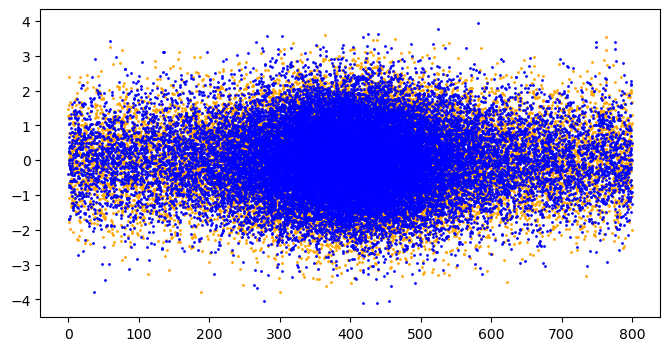

In [23]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)

plt.scatter(x_pic_ion[0, :], v_pic_ion[1, :] / v_thermal_ion, s=1, color='orange')
plt.scatter(x_pic_electron[0, :], v_pic_electron[1, :] / v_thermal_electron, s=1, color='blue')
#plt.ylim(-10, 10)
#plt.xlim(30, 70)
print(x_pic_ion.shape[1], x_pic_electron.shape[1])

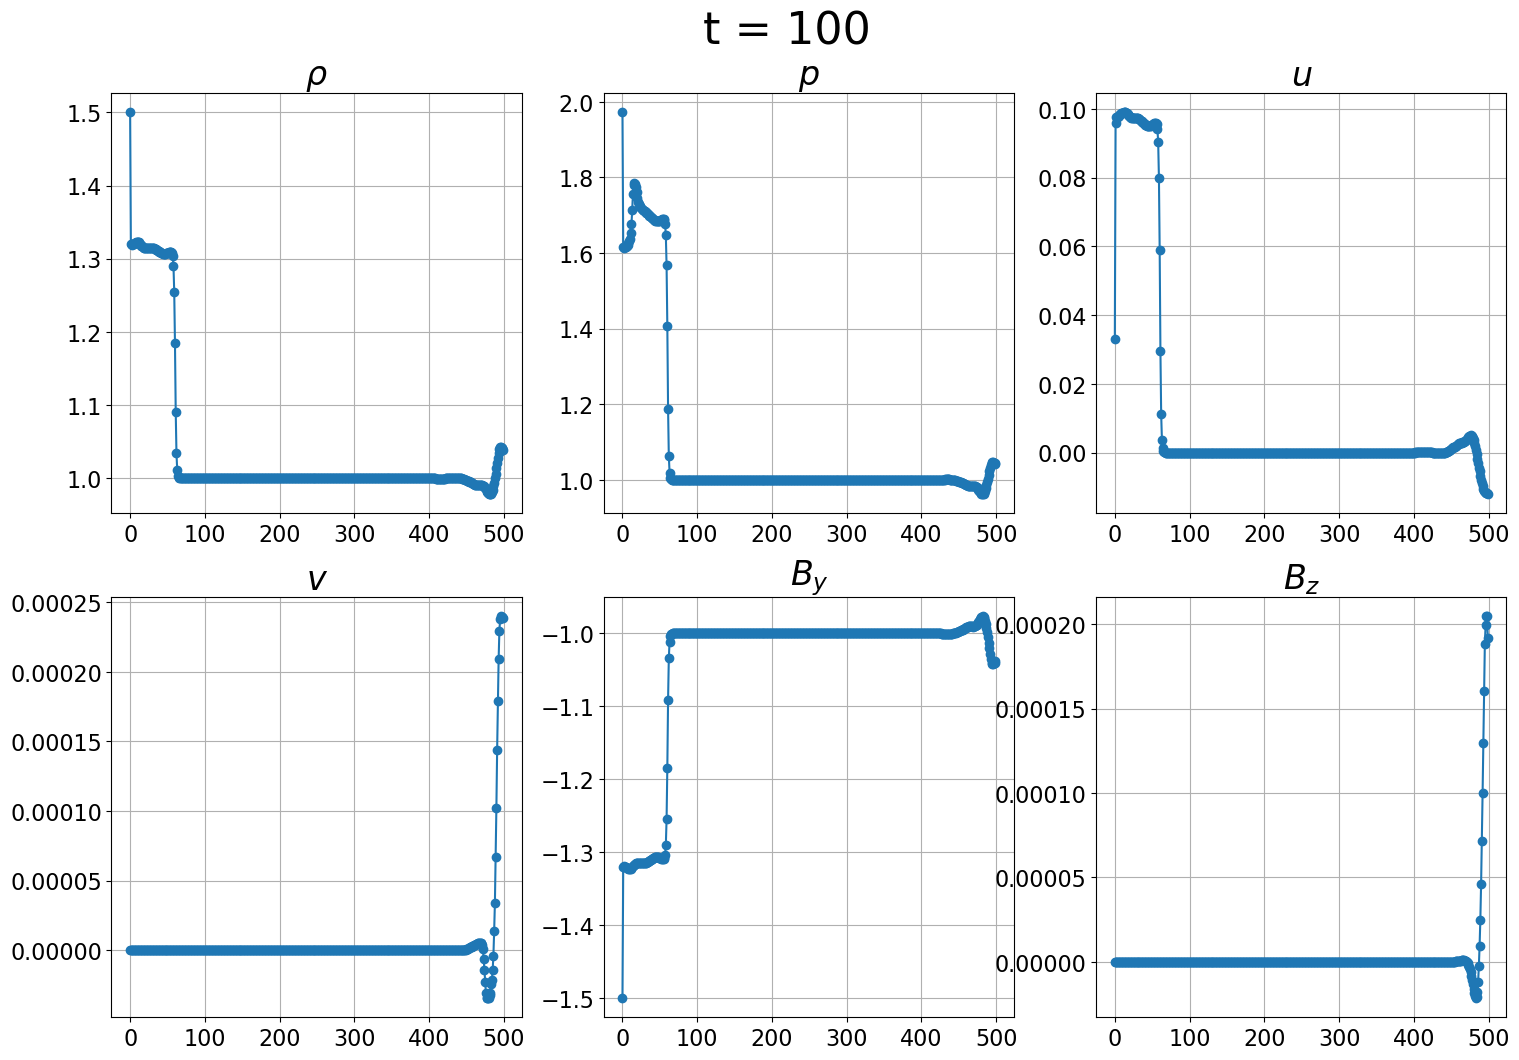

In [24]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

ax1.plot(x_coordinate_mhd, rho1_mhd / rho_init, marker='o')
ax2.plot(x_coordinate_mhd, p1_mhd / p_init, marker='o')
ax3.plot(x_coordinate_mhd, u1_mhd, marker='o')
ax4.plot(x_coordinate_mhd, v1_mhd, marker='o')
ax5.plot(x_coordinate_mhd, By1_mhd / B0_mhd, marker='o')
ax6.plot(x_coordinate_mhd, Bz1_mhd / B0_mhd, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.suptitle(f"t = {step}", y=0.95, fontsize=32)

plt.show()

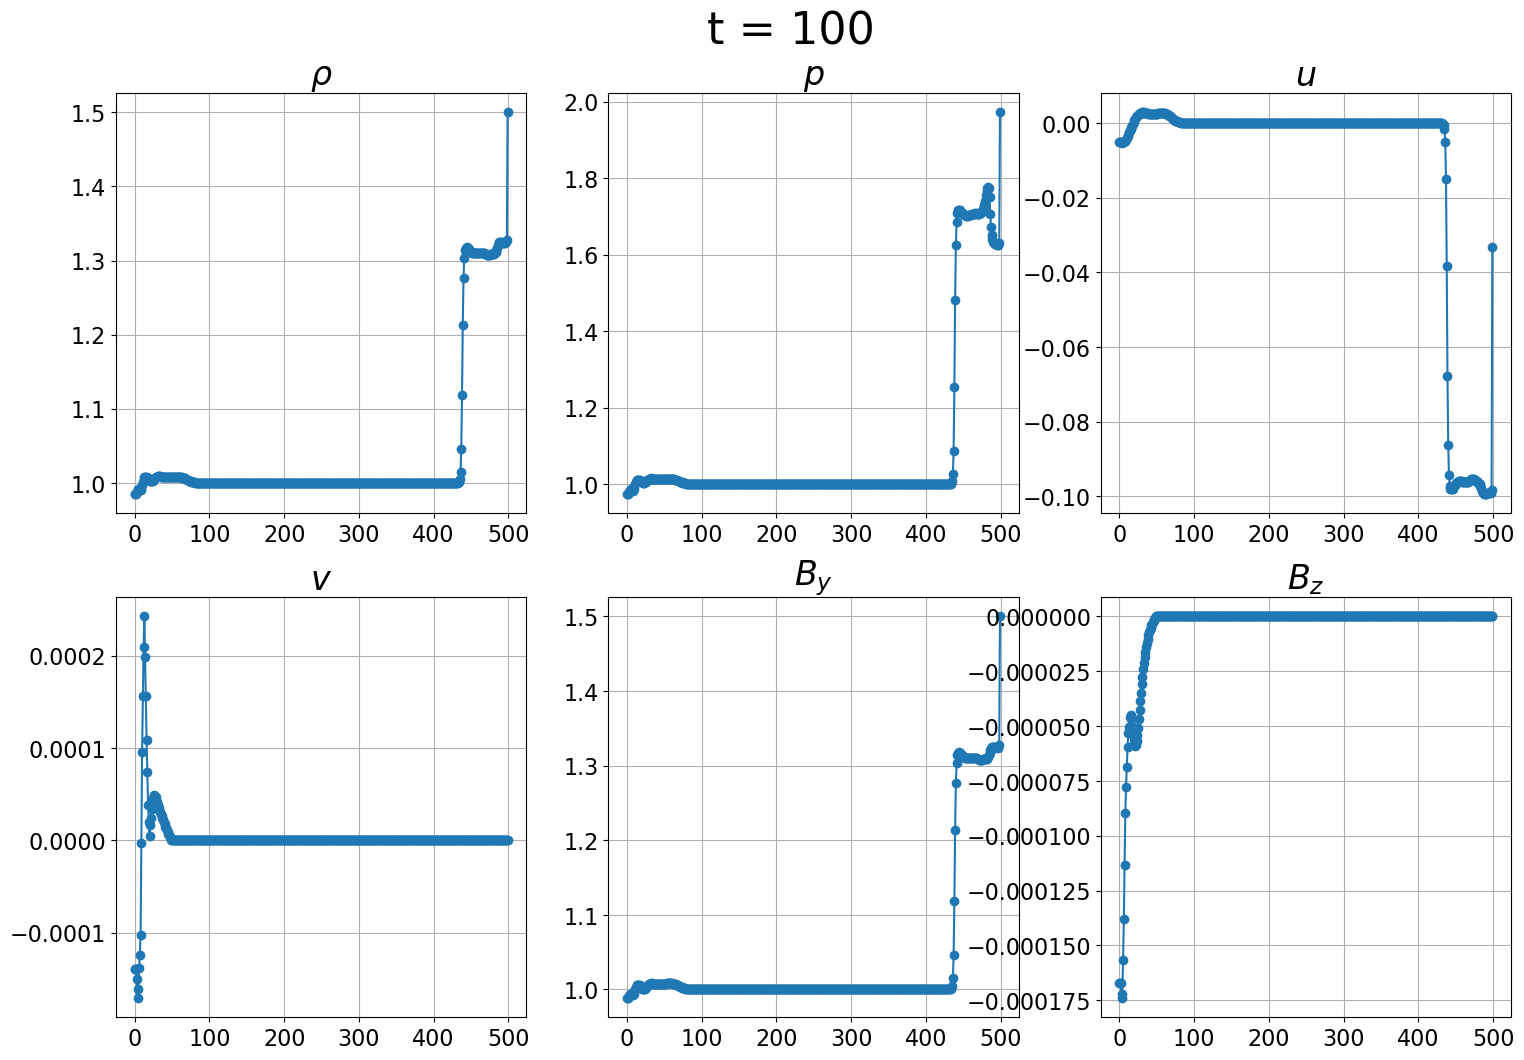

In [25]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

ax1.plot(x_coordinate_mhd, rho2_mhd / rho_init, marker='o')
ax2.plot(x_coordinate_mhd, p2_mhd / p_init, marker='o')
ax3.plot(x_coordinate_mhd, u2_mhd, marker='o')
ax4.plot(x_coordinate_mhd, v2_mhd, marker='o')
ax5.plot(x_coordinate_mhd, By2_mhd / B0_mhd, marker='o')
ax6.plot(x_coordinate_mhd, Bz2_mhd / B0_mhd, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.suptitle(f"t = {step}", y=0.95, fontsize=32)

plt.show()

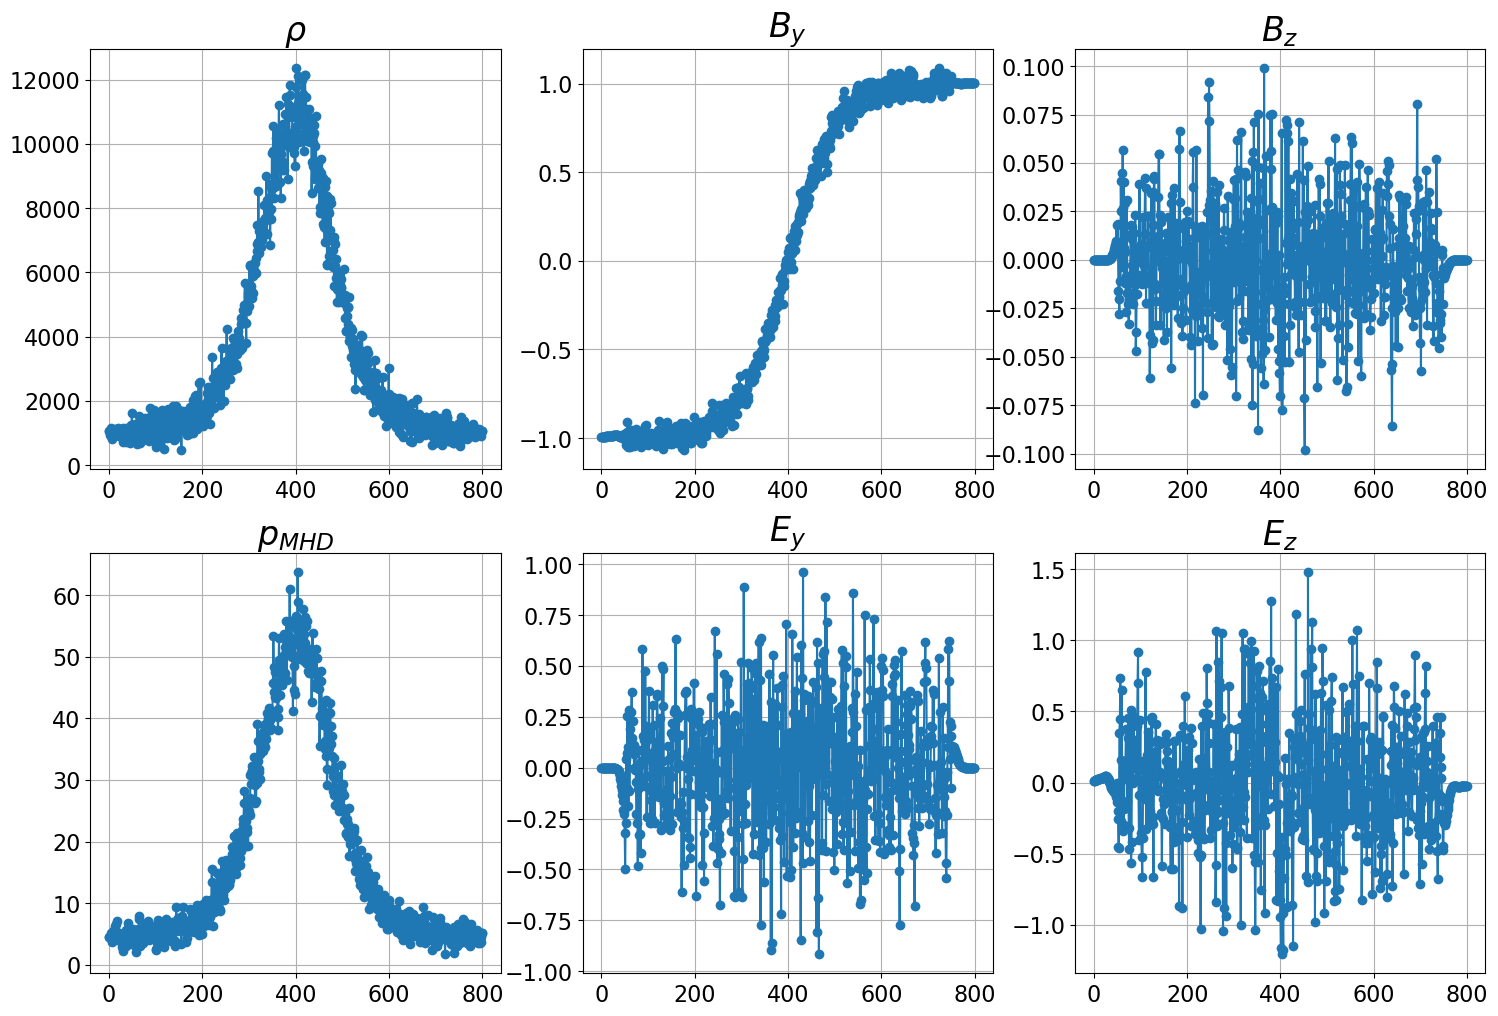

In [26]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho_pic = m_electron * zeroth_moment_electron + m_ion * zeroth_moment_ion
bulk_speed_ion_pic = first_moment_ion / (zeroth_moment_ion + 1e-10)
bulk_speed_electron_pic = first_moment_electron / (zeroth_moment_electron + 1e-10)
bulk_speed_pic = (m_electron * bulk_speed_electron_pic + m_ion * bulk_speed_ion_pic) / (m_electron + m_ion)
v_thi_squared_pic = ((second_moment_ion[0, :] + second_moment_ion[4, :] + second_moment_ion[8, :])
                      - zeroth_moment_ion * (bulk_speed_ion_pic[0, :]**2 + bulk_speed_ion_pic[1, :]**2 + bulk_speed_ion_pic[2, :]**2)) \
                      / 3.0 / (zeroth_moment_ion + 1e-10)
v_the_squared_pic = ((second_moment_electron[0, :] + second_moment_electron[4, :] + second_moment_electron[8, :])
                     - zeroth_moment_electron * (bulk_speed_electron_pic[0, :]**2 + bulk_speed_electron_pic[1, :]**2 + bulk_speed_electron_pic[2, :]**2)) \
                      / 3.0 / (zeroth_moment_electron + 1e-10)
p_pic = zeroth_moment_electron * m_electron * v_the_squared_pic / 2.0 + zeroth_moment_ion * m_ion * v_thi_squared_pic / 2.0
p_mhd = p_pic

ax1.plot(x_coordinate_pic, rho_pic, marker='o')
ax2.plot(x_coordinate_pic, B[1, :] / B0_pic, marker='o')
ax3.plot(x_coordinate_pic, B[2, :] / B0_pic, marker='o')
ax4.plot(x_coordinate_pic, p_mhd, marker='o')
ax5.plot(x_coordinate_pic, E[1, :], marker='o')
ax6.plot(x_coordinate_pic, E[2, :], marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$B_y$", fontsize=24)
ax3.set_title(r"$B_z$", fontsize=24)
ax4.set_title(r"$p_{MHD}$", fontsize=24)
ax5.set_title(r"$E_y$", fontsize=24)
ax6.set_title(r"$E_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

動画作成

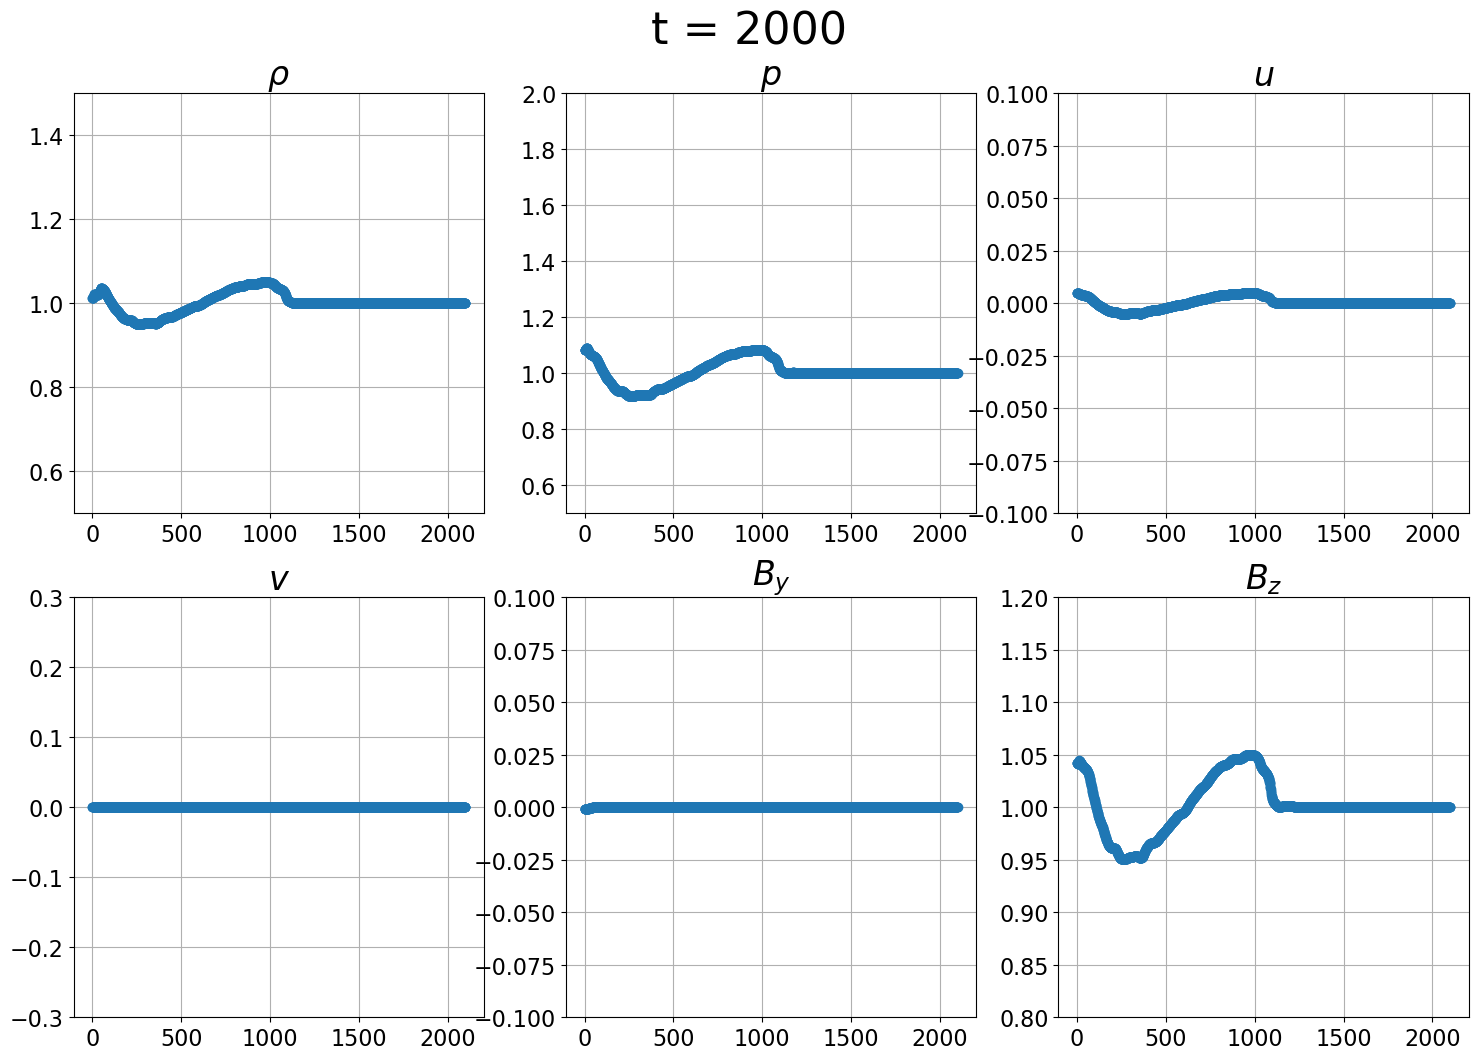

In [ ]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

filename = "Alfven_MHD-PIC_double_MHD_U2.mp4"

interval = 10
plot_steps = steps
for i in range(0, plot_steps+1, interval):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()

    U = np.load(f"results_MH_alfven_double/U2_{i}.npy")
    rho = U[0, :]
    u = U[1, :] / rho 
    v = U[2, :] / rho 
    w = U[3, :] / rho 
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma_mhd-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    ax1.plot(x_coordinate_mhd, rho / rho0_mhd, marker='o')
    ax2.plot(x_coordinate_mhd, p / p0_mhd, marker='o')
    ax3.plot(x_coordinate_mhd, u, marker='o')
    ax4.plot(x_coordinate_mhd, v, marker='o')
    ax5.plot(x_coordinate_mhd, By / B0_mhd, marker='o')
    ax6.plot(x_coordinate_mhd, Bz / B0_mhd, marker='o')

    ax1.set_ylim(0.5, 1.5)
    ax2.set_ylim(0.5, 2.0)
    ax3.set_ylim(-0.1, 0.1)
    ax4.set_ylim(-0.3, 0.3)
    ax5.set_ylim(-0.1, 0.1)
    ax6.set_ylim(0.8, 1.2)

    ax1.set_title(r"$\rho$", fontsize=24)
    ax2.set_title(r"$p$", fontsize=24)
    ax3.set_title(r"$u$", fontsize=24)
    ax4.set_title(r"$v$", fontsize=24)
    ax5.set_title(r"$B_y$", fontsize=24)
    ax6.set_title(r"$B_z$", fontsize=24)
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax3.tick_params(labelsize=16)
    ax4.tick_params(labelsize=16)
    ax5.tick_params(labelsize=16)
    ax6.tick_params(labelsize=16)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    ax5.grid()
    ax6.grid()

    plt.suptitle(f"t = {i}", y=0.95, fontsize=32)

    fig.savefig(f'./pictures/{i}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(0, plot_steps+1, interval):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()

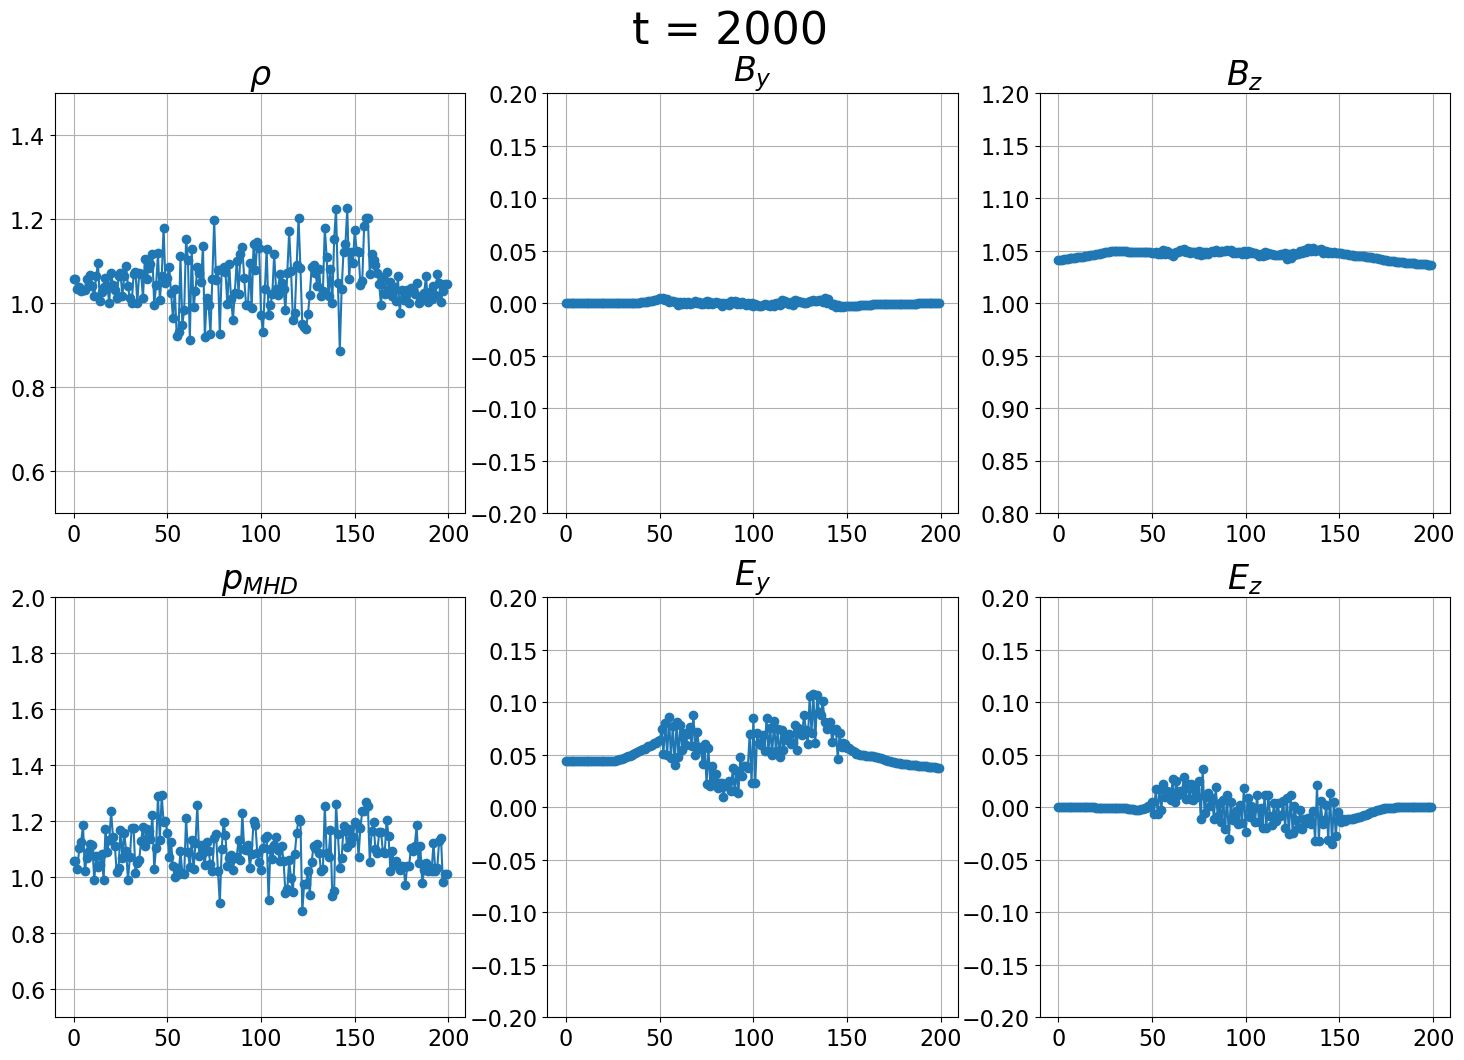

In [ ]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

filename = "Alfven_MHD-PIC_double_PIC.mp4"

interval = 10
plot_steps = steps
for i in range(0, plot_steps+1, interval):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()

    B = np.load(f"results_MH_alfven_double/B_{i}.npy")
    E = np.load(f"results_MH_alfven_double/E_{i}.npy")
    x_pic_ion = np.load(f"results_MH_alfven_double/x_ion_{i}.npy")
    x_pic_electron = np.load(f"results_MH_alfven_double/x_electron_{i}.npy")
    v_pic_ion = np.load(f"results_MH_alfven_double/v_ion_{i}.npy")
    v_pic_electron = np.load(f"results_MH_alfven_double/v_electron_{i}.npy")

    zeroth_moment_ion = np.zeros(nx_pic)
    zeroth_moment_electron = np.zeros(nx_pic)
    zeroth_moment_ion = get_zeroth_moment(x_pic_ion, nx_pic, dx_pic, zeroth_moment_ion)
    zeroth_moment_electron = get_zeroth_moment(x_pic_electron, nx_pic, dx_pic, zeroth_moment_electron)
    first_moment_ion = np.zeros([3, nx_pic])
    first_moment_electron = np.zeros([3, nx_pic])
    first_moment_ion = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, first_moment_ion)
    first_moment_electron = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, first_moment_electron)
    second_moment_ion = np.zeros([9, nx_pic])
    second_moment_electron = np.zeros([9, nx_pic])
    second_moment_ion = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, second_moment_ion)
    second_moment_electron = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, second_moment_electron)

    rho_pic = m_electron * zeroth_moment_electron + m_ion * zeroth_moment_ion
    bulk_speed_ion_pic = first_moment_ion / (zeroth_moment_ion + 1e-10)
    bulk_speed_electron_pic = first_moment_electron / (zeroth_moment_electron + 1e-10)
    bulk_speed_pic = (m_electron * bulk_speed_electron_pic + m_ion * bulk_speed_ion_pic) / (m_electron + m_ion)
    v_thi_squared_pic = ((second_moment_ion[0, :] + second_moment_ion[4, :] + second_moment_ion[8, :])
                      - zeroth_moment_ion * (bulk_speed_ion_pic[0, :]**2 + bulk_speed_ion_pic[1, :]**2 + bulk_speed_ion_pic[2, :]**2)) \
                      / 3.0 / (zeroth_moment_ion + 1e-10)
    v_the_squared_pic = ((second_moment_electron[0, :] + second_moment_electron[4, :] + second_moment_electron[8, :])
                      - zeroth_moment_electron * (bulk_speed_electron_pic[0, :]**2 + bulk_speed_electron_pic[1, :]**2 + bulk_speed_electron_pic[2, :]**2)) \
                      / 3.0 / (zeroth_moment_electron + 1e-10)

    p_pic = zeroth_moment_electron * m_electron * v_the_squared_pic / 2.0 + zeroth_moment_ion * m_ion * v_thi_squared_pic / 2.0
    p_mhd = p_pic

    ax1.plot(x_coordinate_pic, rho_pic / rho0_mhd, marker='o')
    ax2.plot(x_coordinate_pic, B[1, :] / B0_pic, marker='o')
    ax3.plot(x_coordinate_pic, B[2, :] / B0_pic, marker='o')
    ax4.plot(x_coordinate_pic, p_mhd / p0_mhd, marker='o')
    ax5.plot(x_coordinate_pic, E[1, :], marker='o')
    ax6.plot(x_coordinate_pic, E[2, :], marker='o')

    ax1.set_ylim(0.5, 1.5)
    ax2.set_ylim(-0.2, 0.2)
    ax3.set_ylim(0.8, 1.2)
    ax4.set_ylim(0.5, 2.0)
    ax5.set_ylim(-0.2, 0.2)
    ax6.set_ylim(-0.2, 0.2)

    ax1.set_title(r"$\rho$", fontsize=24)
    ax2.set_title(r"$B_y$", fontsize=24)
    ax3.set_title(r"$B_z$", fontsize=24)
    ax4.set_title(r"$p_{MHD}$", fontsize=24)
    ax5.set_title(r"$E_y$", fontsize=24)
    ax6.set_title(r"$E_z$", fontsize=24)
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax3.tick_params(labelsize=16)
    ax4.tick_params(labelsize=16)
    ax5.tick_params(labelsize=16)
    ax6.tick_params(labelsize=16)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    ax5.grid()
    ax6.grid()

    plt.suptitle(f"t = {i}", y=0.95, fontsize=32)

    fig.savefig(f'./pictures/{i}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(0, plot_steps+1, interval):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()

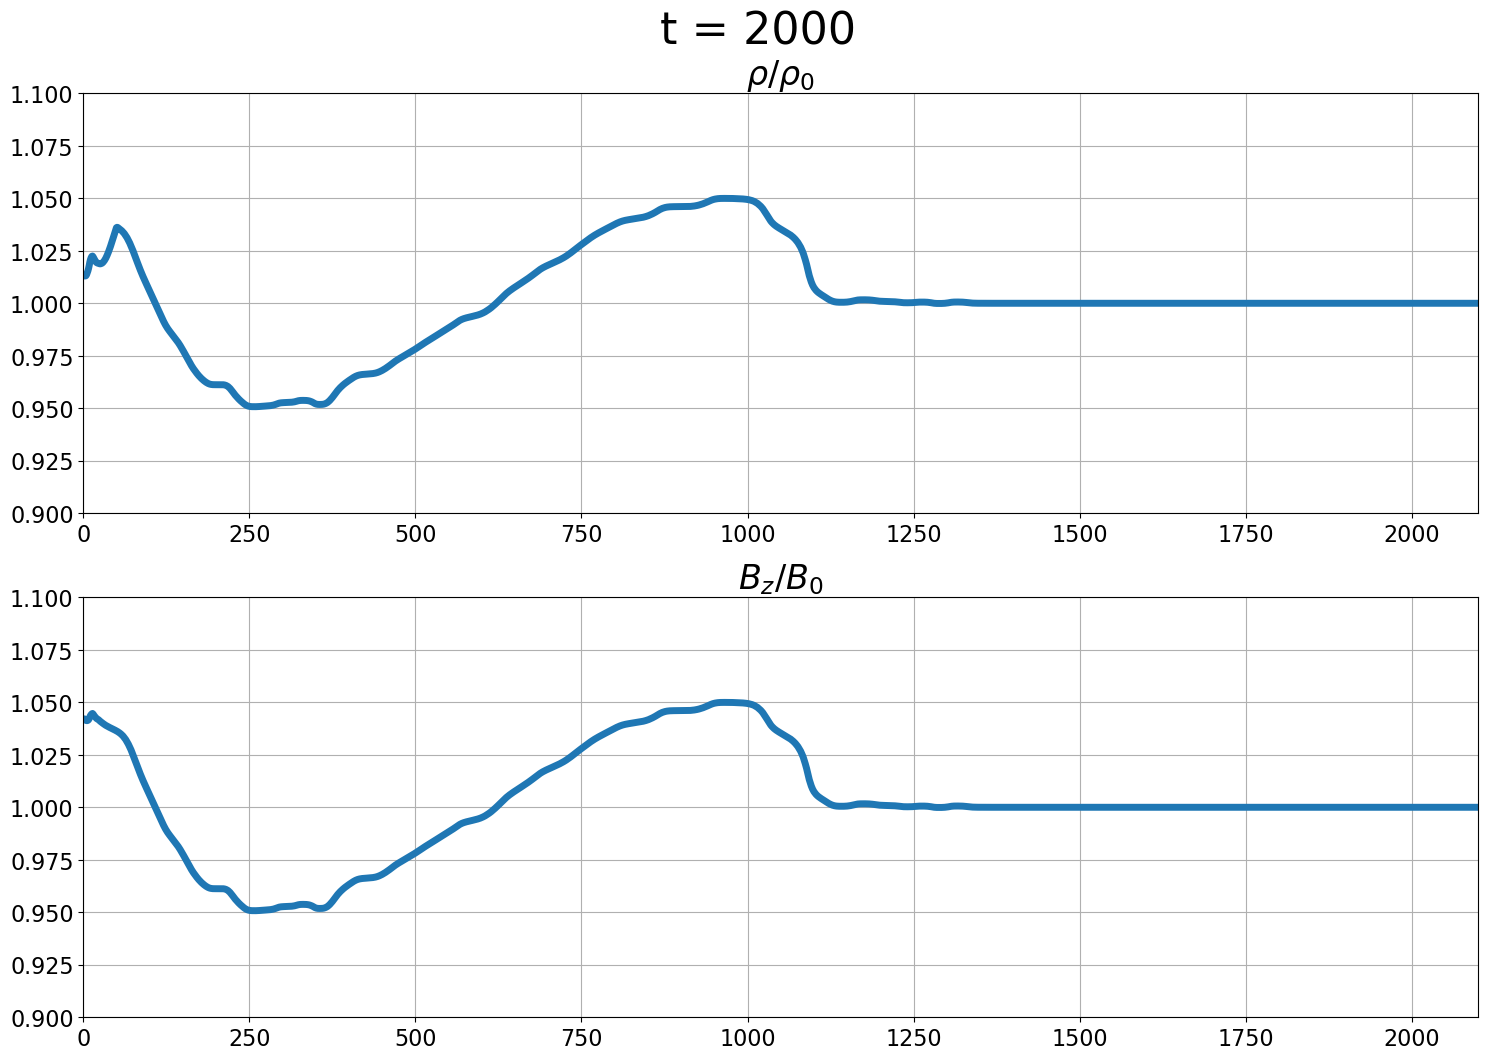

In [42]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

filename = "Alfven_MHD-PIC_double_MHD_rhoB_U2.mp4"

interval = 10
plot_steps = steps
for i in range(0, plot_steps+1, interval):
    ax1.clear()
    ax2.clear()

    U = np.load(f"results_MH_alfven_double/U2_{i}.npy")
    rho = U[0, :]
    u = U[1, :] / rho 
    v = U[2, :] / rho 
    w = U[3, :] / rho 
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma_mhd-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    ax1.plot(x_coordinate_mhd, rho / rho0_mhd, lw=5)
    ax2.plot(x_coordinate_mhd, Bz / B0_mhd, lw=5)

    ax1.set_xlim(x_min_mhd, x_max_mhd)
    ax2.set_xlim(x_min_mhd, x_max_mhd)
    ax1.set_ylim(0.9, 1.1)
    ax2.set_ylim(0.9, 1.1)

    ax1.set_title(r"$\rho / \rho_0$", fontsize=24)
    ax2.set_title(r"$B_z / B_0$", fontsize=24)
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax1.grid()
    ax2.grid()

    plt.suptitle(f"t = {i}", y=0.95, fontsize=32)

    fig.savefig(f'./pictures/{i}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(0, plot_steps+1, interval):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()

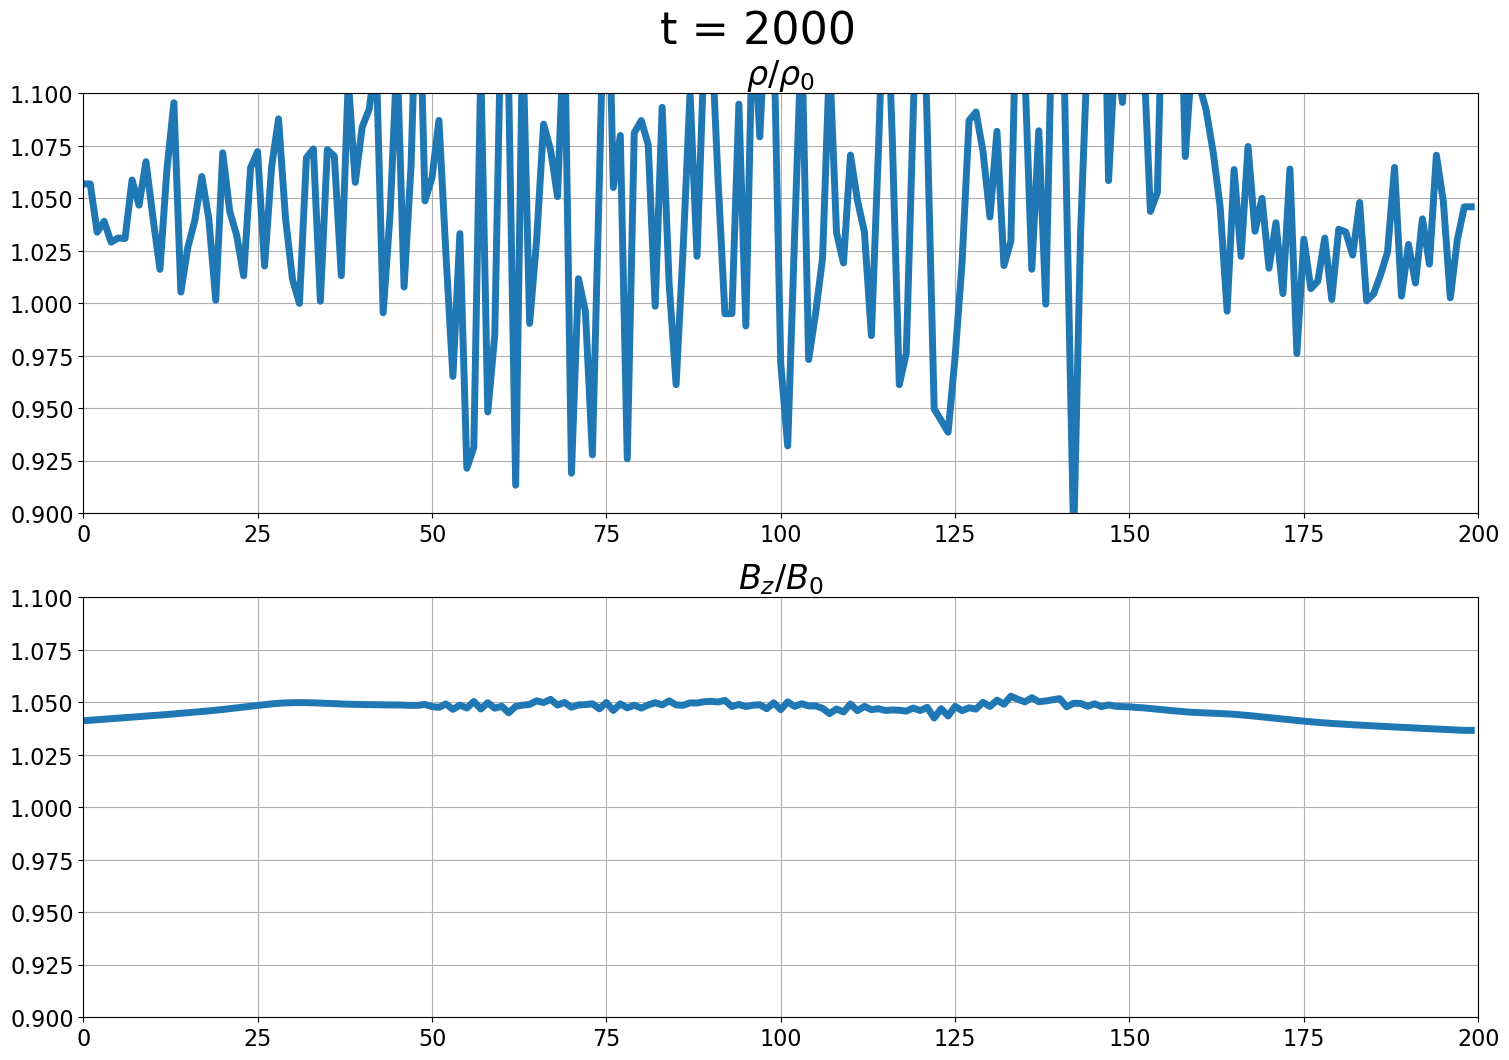

In [40]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

filename = "Alfven_MHD-PIC_double_PIC_rhoB_U1.mp4"

interval = 10
plot_steps = steps
for i in range(0, plot_steps+1, interval):
    ax1.clear()
    ax2.clear()

    B = np.load(f"results_MH_alfven_double/B_{i}.npy")
    E = np.load(f"results_MH_alfven_double/E_{i}.npy")
    x_pic_ion = np.load(f"results_MH_alfven_double/x_ion_{i}.npy")
    x_pic_electron = np.load(f"results_MH_alfven_double/x_electron_{i}.npy")
    v_pic_ion = np.load(f"results_MH_alfven_double/v_ion_{i}.npy")
    v_pic_electron = np.load(f"results_MH_alfven_double/v_electron_{i}.npy")

    zeroth_moment_ion = np.zeros(nx_pic)
    zeroth_moment_electron = np.zeros(nx_pic)
    zeroth_moment_ion = get_zeroth_moment(x_pic_ion, nx_pic, dx_pic, zeroth_moment_ion)
    zeroth_moment_electron = get_zeroth_moment(x_pic_electron, nx_pic, dx_pic, zeroth_moment_electron)
    first_moment_ion = np.zeros([3, nx_pic])
    first_moment_electron = np.zeros([3, nx_pic])
    first_moment_ion = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, first_moment_ion)
    first_moment_electron = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, first_moment_electron)
    second_moment_ion = np.zeros([9, nx_pic])
    second_moment_electron = np.zeros([9, nx_pic])
    second_moment_ion = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, second_moment_ion)
    second_moment_electron = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, second_moment_electron)

    rho_pic = m_electron * zeroth_moment_electron + m_ion * zeroth_moment_ion
    

    ax1.plot(x_coordinate_pic, rho_pic / rho0_mhd, lw=5)
    ax2.plot(x_coordinate_pic, B[2, :] / B0_mhd, lw=5)

    ax1.set_xlim(x_min_pic, x_max_pic)
    ax2.set_xlim(x_min_pic, x_max_pic)
    ax1.set_ylim(0.9, 1.1)
    ax2.set_ylim(0.9, 1.1)

    ax1.set_title(r"$\rho / \rho_0$", fontsize=24)
    ax2.set_title(r"$B_z / B_0$", fontsize=24)
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax1.grid()
    ax2.grid()

    plt.suptitle(f"t = {i}", y=0.95, fontsize=32)

    fig.savefig(f'./pictures/{i}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(0, plot_steps+1, interval):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()